<a href="https://colab.research.google.com/github/misbahsy/APMonitor-do/blob/master/ControlTypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control

<p class='vspace'>There are many methods to implement control including basic strategies such as a proportional-integral-derivative (PID) controller or more advanced methods such as model predictive techniques. The purpose of this section is to provide a tutorial overview of potential strategies for control of nonlinear systems with linear models.
</p>

<p class='vspace'>A following section relates methods to <a class='wikilink' href='http://apmonitor.com/do/index.php/Main/NonlinearControl'>implement dynamic control with nonlinear models</a>.
</p>

In [1]:
#@title
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/YHAA-uXhI0E?rel=0" frameborder="0" allowfullscreen></iframe>


##Exercise
<p><strong>Objective:</strong> Design a model predictive controller for an overhead crane. Meet specific control objectives by tuning the controller and using the state space model of the crane system. Simulate and optimize the pendulum system with an adjustable overhead cart. <em>Estimated time: 2 hours.</em>
</p>
<p class='vspace'>A pendulum is described by the following dynamic equations:
</p>
<p class='vspace'>$$\begin{bmatrix} \dot y \\ \dot v \\ \dot \theta \\ \dot q \end{bmatrix}=\begin{bmatrix} 0 &amp; 1 &amp; 0 &amp; 0\\ 0 &amp; 0 &amp; \epsilon &amp; 0\\ 0 &amp; 0 &amp; 0 &amp; 1\\ 0 &amp; 0 &amp; -1 &amp; 0 \end{bmatrix} \begin{bmatrix} y \\ v \\ \theta \\ q \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \\ 0 \\ -1 \end{bmatrix} u$$
</p>
<p class='vspace'>where <em>m<sub>1</sub>=10</em> is the mass of the cart, <em>m<sub>2</sub>=1</em> is the mass of the item carried, `\epsilon` is <em>m<sub>2</sub>/(m<sub>1</sub>+m<sub>2</sub>)</em>, <em>y</em> is the position of the overhead cart, <em>v</em> is the velocity of the overhead cart, `\theta` is the angle of the pendulum relative to the cart, and <em>q</em> is the rate of angle change<sup>2</sup>.
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/pendulum_crane.png' alt='' title='' /></div>
<p class='vspace'>The objective of the controller is to adjust the force on the cart to move the pendulum mass to a new final position. Ensure that initial and final velocities and angles of the pendulum are zero. The position of the pendulum mass is initially at -1 and it is desired to move it to the new position of 0 within 6.2 seconds. Demonstrate controller performance with changes in the pendulum position and that the final pendulum mass remains at the final position without oscillation. How does the solution change if the mass of the item carried is increased to <em>m<sub>2</sub>=5</em>?
</p>

In [2]:
#@title ##Solution
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/clMBeJ3FI_g" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>



<p class='vspace'><strong>Solution with <em>m<sub>2</sub></em>=1</strong>
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/crane_pendulum.png' alt='' title='' /></div>
<p class='vspace'><strong>Solution with <em>m<sub>2</sub></em>=5</strong>
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/crane_pendulum5.png' alt='' title='' /></div>

apm 35.230.39.168_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            8
   Intermediates:            0
   Connections  :            0
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:            630
 Number of total equations: -          560
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             70
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

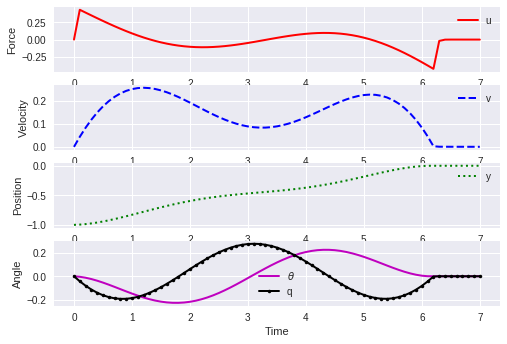

In [3]:
#@markdown Solution with GEKKO

try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])

#%%Import packages
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

#%% Build model

#initialize GEKKO model
m = GEKKO()

#time
m.time = np.linspace(0,7,71)

#Parameters
mass1 = m.Param(value=10)
mass2 = m.Param(value=1)
final = np.zeros(np.size(m.time))
for i in range(np.size(m.time)):
    if m.time[i] >= 6.2:
        final[i] = 1
    else:   
        final[i] = 0
final = m.Param(value=final)

#Manipulated variable
u = m.Var(value=0)

#Variables
theta = m.Var(value=0)
q = m.Var(value=0)
#Controlled Variable
y = m.Var(value=-1)
v = m.Var(value=0)

#Equations
m.Equations([y.dt() == v,
             v.dt() == mass2/(mass1+mass2) * theta + u,
             theta.dt() == q,
             q.dt() == -theta - u])

#Objective
m.Obj(final * (y**2 + v**2 + theta**2 + q**2))
m.Obj(0.001 * u**2)


#%% Tuning
#global
m.options.IMODE = 6 #control

#%% Solve
m.solve()

#%% Plot solution
plt.figure()
plt.subplot(4,1,1)
plt.plot(m.time,u.value,'r-',LineWidth=2)
plt.ylabel('Force')
plt.legend(['u'],loc='best')
plt.subplot(4,1,2)
plt.plot(m.time,v.value,'b--',LineWidth=2)
plt.legend(['v'],loc='best')
plt.ylabel('Velocity')
plt.subplot(4,1,3)
plt.plot(m.time,y.value,'g:',LineWidth=2)
plt.legend(['y'],loc='best')
plt.ylabel('Position')
plt.subplot(4,1,4)
plt.plot(m.time,theta.value,'m-',LineWidth=2)
plt.plot(m.time,q.value,'k.-',LineWidth=2)
plt.legend([r'$\theta$','q'],loc='best')
plt.ylabel('Angle')
plt.xlabel('Time')
plt.show()

apm 35.230.39.168_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            8
   Intermediates:            1
   Connections  :            0
   Equations    :           10
   Residuals    :            9
 
 Number of state variables:            891
 Number of total equations: -          792
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             99
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

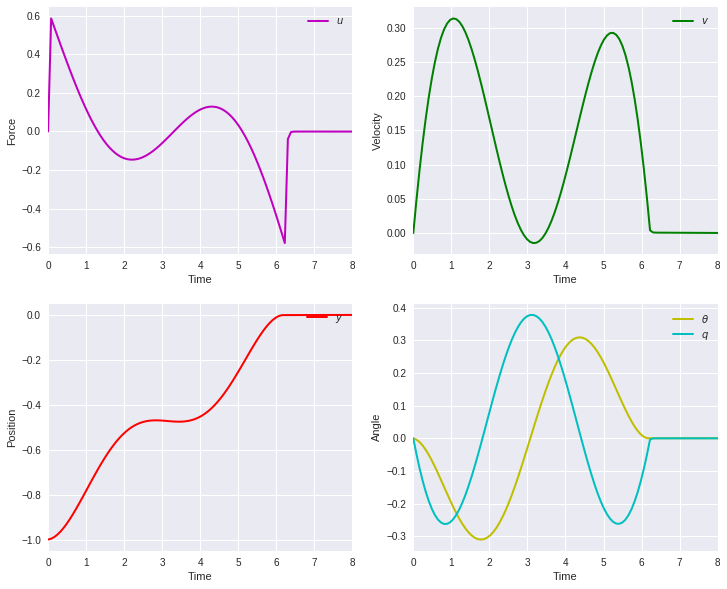

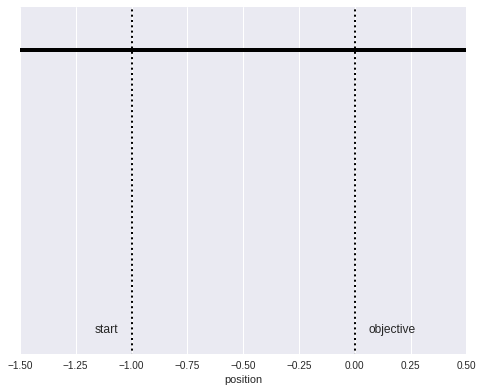

In [4]:
#@markdown Solution using GEKKO using Animation

# Contributed by Everton Colling
import matplotlib.animation as animation
import numpy as np
from gekko import GEKKO
# requires ffmpeg to save mp4 file
#  available from https://ffmpeg.zeranoe.com/builds/
#  add ffmpeg.exe to path such as C:\ffmpeg\bin\ in
#  environment variables

#Defining a model
m = GEKKO()

#################################
#Weight of item
m2 = 5
#################################

#Defining the time, we will go beyond the 6.2s
#to check if the objective was achieved
m.time = np.linspace(0,8,100)

#Parameters
m1a = m.Param(value=10)
m2a = m.Param(value=m2)
final = np.zeros(len(m.time))
for i in range(len(m.time)):
    if m.time[i] < 6.2:
        final[i] = 0
    else:
        final[i] = 1
final = m.Param(value=final)

#MV
ua = m.Var(value=0)

#State Variables
theta_a = m.Var(value=0)
qa = m.Var(value=0)
ya = m.Var(value=-1)
va = m.Var(value=0)

#Intermediates
epsilon = m.Intermediate(m2a/(m1a+m2a))

#Defining the State Space Model
m.Equation(ya.dt() == va)
m.Equation(va.dt() == epsilon*theta_a + ua)
m.Equation(theta_a.dt() == qa)
m.Equation(qa.dt() == -theta_a -ua)

#Definine the Objectives
#Make all the state variables be zero at time >= 6.2
m.Obj(final*ya**2)
m.Obj(final*va**2)
m.Obj(final*theta_a**2)
m.Obj(final*qa**2)
#Try to minimize change of MV over all horizon
m.Obj(0.001*ua**2)

m.options.IMODE = 6 #MPC
m.solve() #(disp=False)

#Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(m.time,ua.value,'m',lw=2)
plt.legend([r'$u$'],loc=1)
plt.ylabel('Force')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(222)
plt.plot(m.time,va.value,'g',lw=2)
plt.legend([r'$v$'],loc=1)
plt.ylabel('Velocity')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(223)
plt.plot(m.time,ya.value,'r',lw=2)
plt.legend([r'$y$'],loc=1)
plt.ylabel('Position')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(224)
plt.plot(m.time,theta_a.value,'y',lw=2)
plt.plot(m.time,qa.value,'c',lw=2)
plt.legend([r'$\theta$',r'$q$'],loc=1)
plt.ylabel('Angle')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.rcParams['animation.html'] = 'html5'

x1 = ya.value
y1 = np.zeros(len(m.time))

#suppose that l = 1
x2 = 1*np.sin(theta_a.value)+x1
x2b = 1.05*np.sin(theta_a.value)+x1
y2 = -1*np.cos(theta_a.value)+y1
y2b = -1.05*np.cos(theta_a.value)+y1

fig = plt.figure(figsize=(8,6.4))
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-1.5,0.5),ylim=(-1.2,0.4))
ax.set_xlabel('position')
ax.get_yaxis().set_visible(False)

crane_rail, = ax.plot([-1.5,0.5],[0.2,0.2],'k-',lw=4)
start, = ax.plot([-1,-1],[-1.5,1],'k:',lw=2)
objective, = ax.plot([0,0],[-1.5,1],'k:',lw=2)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='orange',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)
start_text = ax.text(-1.06,-1.1,'start',ha='right')
end_text = ax.text(0.06,-1.1,'objective',ha='left')

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    return line, mass1, mass2, time_text

def animate(i):
    mass1.set_data([x1[i]],[y1[i]+0.1])
    mass2.set_data([x2b[i]],[y2b[i]])
    line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
    time_text.set_text(time_template % m.time[i])
    return line, mass1, mass2, time_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(m.time)), \
         interval=40,blit=False,init_func=init)

ani_a.save('Pendulum_Control.mp4',fps=30)

plt.show()

apm 35.230.39.168_gk_model2 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :           10
   Intermediates:            0
   Connections  :            9
   Equations    :            1
   Residuals    :            1
 
 
 LTI Model Statistics
 -------------------------------------
 Sparse Matrices
 Continuous Form
 Matrix    Dimension    Non-zeros
   A                 4 x           4                 4
   B                 4 x           1                 2
   C                 4 x           4                 4
   D                 4 x           1                 0
   E                 4 x           4                 4
 -------------------------------------
 
 Number of state variables:           610

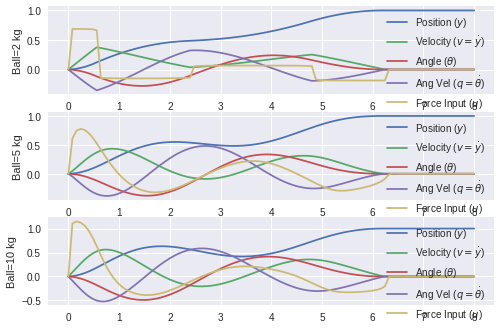

In [5]:
#@markdown Solution using GEKKO for State Space Model and Controller

import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

mass = [2,5,10]
nm = len(mass)
plt.figure()

for j in range(len(mass)):
    m1 = 10
    m2 = mass[j]
    eps = m2/(m1+m2)
    A = np.array([[0,1,0,0],
                 [0,0,eps,0],
                 [0,0,0,1],
                 [0,0,-1,0]])
    B = np.array([[0],
                 [1],
                 [0],
                 [-1]])
    C = np.identity(4)

    m = GEKKO()
    x,y,u = m.state_space(A,B,C,D=None)
    m.time = np.linspace(0,8,101)
    fn = [0 if m.time[i]<6.2 else 1 for i in range(101)]      
    final = m.Param(value=fn)
    u[0].status = 1
    m.Obj(final * ((y[0]-1)**2 + y[1]**2 + y[2]**2 + y[3]**2))    
    m.options.IMODE = 6
    m.solve()

    plt.subplot(len(mass),1,j+1)
    plt.ylabel(f'Ball={mass[j]} kg')
    plt.plot(m.time,y[0], label = r"Position ($y$)")
    plt.plot(m.time,y[1], label = r"Velocity ($v=\dot y$)")
    plt.plot(m.time,y[2], label = r"Angle ($\theta$)")
    plt.plot(m.time,y[3], label = r"Ang Vel ($q=\dot \theta$)")
    plt.plot(m.time,u[0], label = r"Force Input ($u$)")
    plt.legend(loc=1)
plt.show()

In [6]:
#@title
%%html
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/crane_control.zip' rel='nofollow'>Crane Pendulum Solution Files in MATLAB and Python</a></div>
<div class='vspace'></div>
<iframe width="560" height="315" src="https://www.youtube.com/embed/iTaz8ro-4D4" frameborder="0" allowfullscreen></iframe>
